### Step 9: Pricing Estimation – Pure Premium Calculation

In this final step of the project, we compute the **pure premium** for each policyholder by combining the previously modeled **claim frequency** and **claim severity**.

--

#### Input Datasets

- `df_freq_sev_v2`: Contains one row per policy, with the predicted claim frequency (*freq_pred*).
- `df_freq_sev_v3`: Also contains one row per policy (merged earlier by *IDpol*), with the predicted claim severity (*sev_pred*). This column was computed only for policies with observed claims, and left as missing (*NaN*) for others.

--

#### Goal

- Join the two datasets on *IDpol*
- Compute the **expected pure premium** as:

$$
\text{pure\_premium} = \text{freq\_pred} \times \text{sev\_pred}
$$

This pure premium represents the **expected annual claim cost per policy**, and serves as the foundation for technical pricing and tariff calibration.

--

#### Notes

- Policies without prior claims received *sev_pred = 0*, assuming no expected severity.
- Final analysis will explore the distribution of pure premiums and allow for segmentation, calibration, or risk grouping.

This step ties together the entire modeling pipeline and produces the final, monetized outcome used in actuarial decision-making.

In [1]:
import pandas as pd
import numpy as np

# Load datasets
freq_df = pd.read_csv("../data/df_freq_sev_v2.csv")
sev_df = pd.read_csv("../data/df_freq_sev_v3.csv")

# Merge sev_pred into freq_df
pricing_df = freq_df.merge(
    sev_df[['IDpol', 'sev_pred']], on='IDpol', how='left'
)

# Fill missing severity predictions with 0
pricing_df['sev_pred'] = pricing_df['sev_pred'].fillna(0.0)

# Expected pure premium
pricing_df['pure_premium'] = pricing_df['freq_pred'] * pricing_df['sev_pred']

# Log-transform for better visualization
pricing_df['log_pure_premium'] = np.log1p(pricing_df['pure_premium'])

# Preview
pricing_df[['IDpol', 'freq_pred', 'sev_pred', 'pure_premium']].head()


,IDpol,freq_pred,sev_pred,pure_premium
0,1,0.026129,0.0,0.0
1,3,0.201192,0.0,0.0
2,5,0.067096,0.0,0.0
3,10,0.017885,0.0,0.0
4,11,0.166923,0.0,0.0


#### Step 9.A: Pricing Segmentation

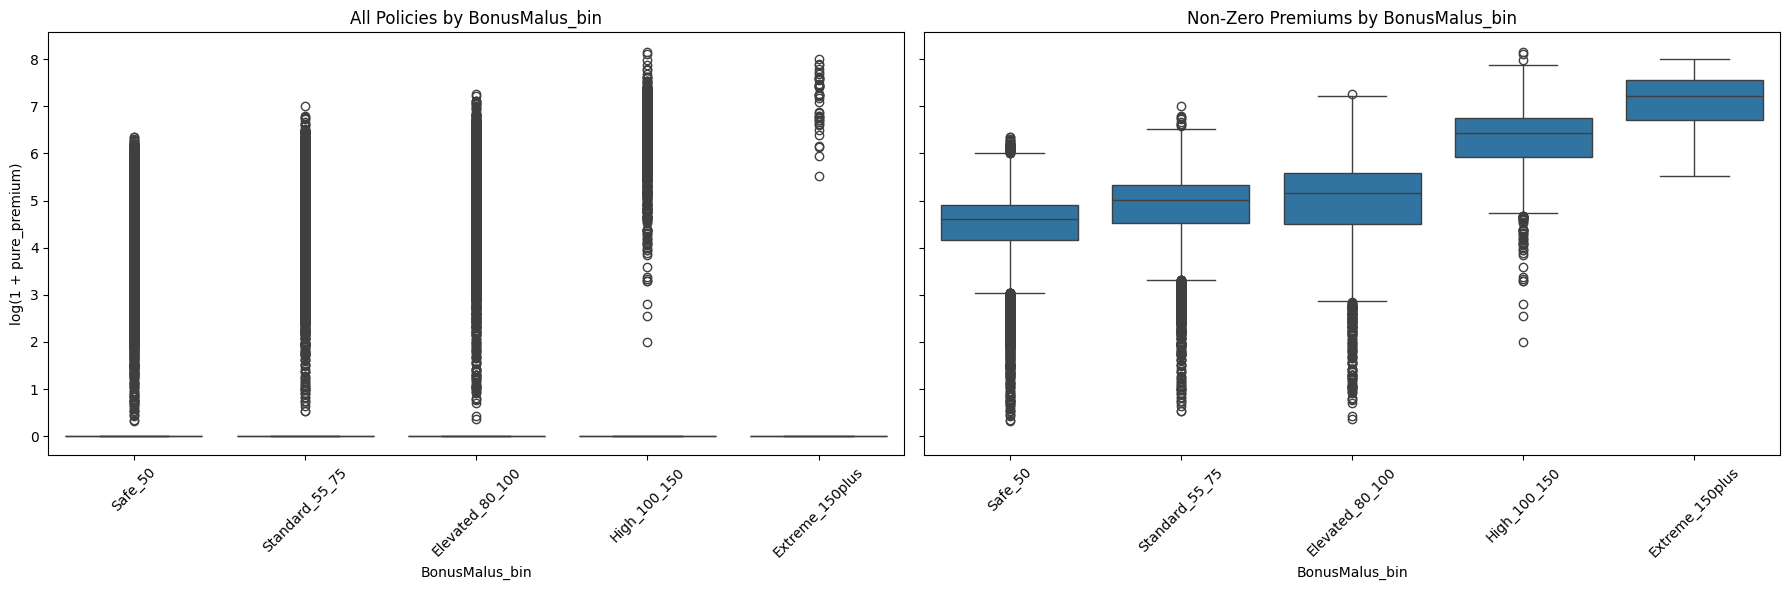

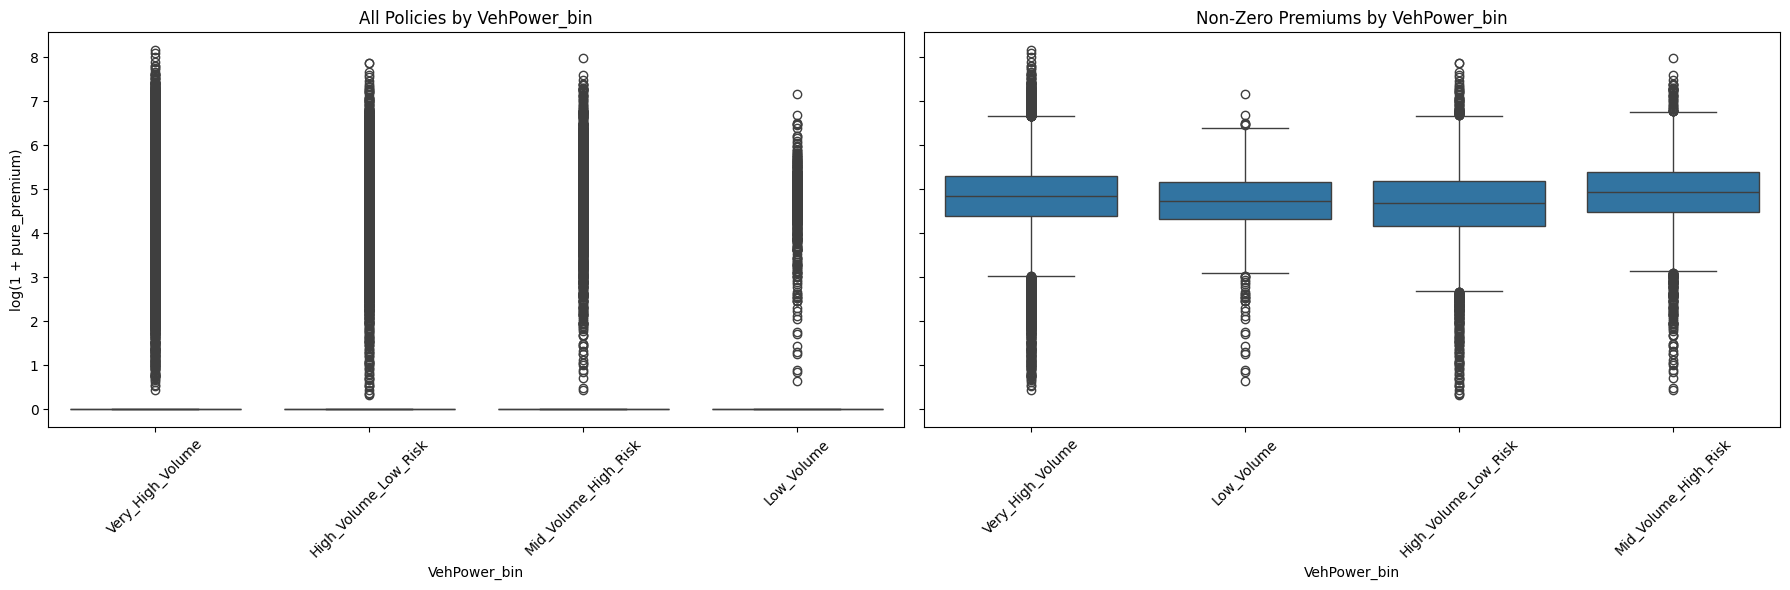

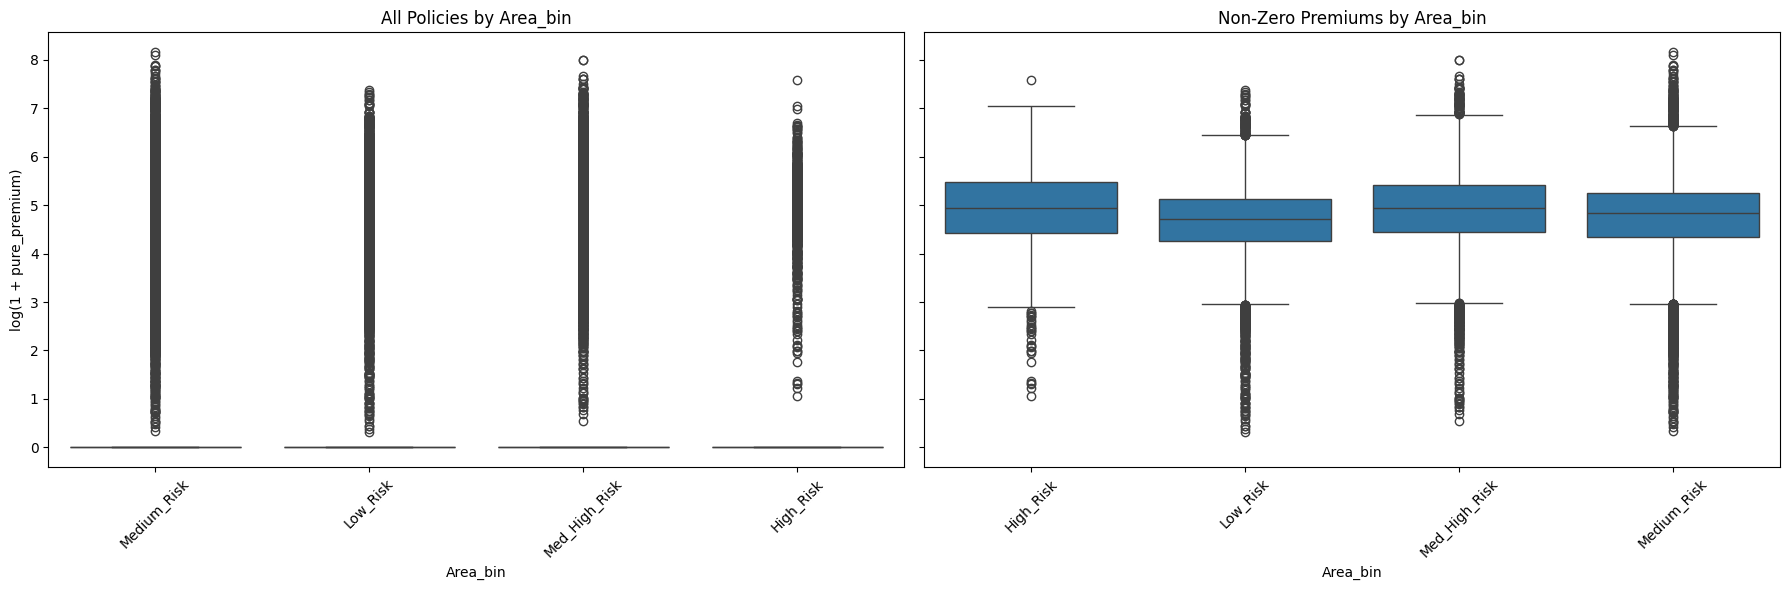

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Segments
segment_vars = ['BonusMalus_bin', 'VehPower_bin', 'Area_bin']

for var in segment_vars:
    df_full = pricing_df.copy()
    df_nonzero = pricing_df[pricing_df['pure_premium'] > 0].copy()

    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    # Full population
    sns.boxplot(ax=axes[0], data=df_full, x=var, y='log_pure_premium')
    axes[0].set_title(f"All Policies by {var}")
    axes[0].set_xlabel(var)
    axes[0].set_ylabel("log(1 + pure_premium)")
    axes[0].tick_params(axis='x', rotation=45)

    # Only non-zero premiums
    sns.boxplot(ax=axes[1], data=df_nonzero, x=var, y='log_pure_premium')
    axes[1].set_title(f"Non-Zero Premiums by {var}")
    axes[1].set_xlabel(var)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


#### Step 9 Summary: Segmentation – log(1 + Pure Premium) by Key Risk Bins

To better understand how technical pricing varies across major risk features, we visualized the **log-transformed pure premium** (*log(1 + pure_premium)*) across key binned variables using dual boxplots:

- **Left Panel**: All policyholders (including zero-valued premiums)
- **Right Panel**: Only policies with *pure_premium > 0* (i.e., non-zero expected loss cost)

--

##### Observations by Segment

- **BonusMalus_bin**  
  - Displays a **clear upward trend** in median and upper quantiles as risk tier increases.
  - The *Extreme_150plus* group shows dramatically higher severity and spread than *Safe_50*.
  - **Excellent segmentation power** — reinforces its strong predictive contribution from both frequency and severity models.

- **VehPower_bin**  
  - Slight differentiation observed, particularly for *Mid_Volume_High_Risk* and *Very_High_Volume* groups in the non-zero plot.
  - Indicates **moderate discriminatory capacity** when considered alone, but likely more powerful in interaction with other features such as BonusMalus or vehicle brand.

- **Area_bin**  
  - Risk group separation is **less pronounced**.
  - While *High_Risk* and *Med_High_Risk* bins show a marginally wider spread, there is substantial overlap.
  - Suggests **limited standalone pricing value**, but still important as a **regional signal or interaction term**.

--

##### Summary

These visualizations confirm that **BonusMalus_bin is the strongest single driver of pure premium variation**, while **VehPower_bin** and **Area_bin** support segmentation when combined with contextual or behavioral features.

This step finalizes the pricing pipeline by validating the predicted premium’s discriminatory ability and informing potential tariff structure designs.

---